# Employee Promotion Prediction


## Background & Context

Employee Promotion means the ascension of an employee to higher ranks, this aspect of the job is what drives employees the most.
The ultimate reward for dedication and loyalty towards an organization and HR team plays an important role in handling all these promotion tasks based on ratings and other attributes available.

The HR team in JMD company stored data of promotion cycle last year, which consists of details of all the employees in the company working last year and also
if they got promoted or not, but every time this process gets delayed due to so many details available for each employee - it gets difficult to compare and decide.

So this time HR team wants to utilize the stored data to make a model, that will predict if a person is eligible for promotion or not.

We as a data scientist at JMD company, need to come up with a model that will help the HR team to predict if a person is eligible for promotion or not.

### Objective

* Explore and visualize the dataset.
* Build a classification model to predict if the employee has a higher probability of getting a promotion
* Optimize the model using appropriate techniques
* Generate a set of insights and recommendations that will help the company

### Data Dictionary:

* **employee_id**: Unique ID for the employee
* **department**: Department of employee
* **region**: Region of employment (unordered)
* **education**: Education Level
* **gender**: Gender of Employee
* **recruitment_channel**: Channel of recruitment for employee
* **no_of_trainings**: no of other trainings completed in the previous year on soft skills, technical skills, etc.
* **age**: Age of Employee
* **previous_year_rating**: Employee Rating for the previous year
* **length_of_service**: Length of service in years
* **awards_won**: if awards won during the previous year then 1 else 0
* **avg_training_** score: Average score in current training evaluations
* **is_promoted**: (Target) Recommended for promotion

In [1]:
# Course: Feature Selection, Model Selection and Tuning
# Project: Employee Promotion Prediction
# Student: Sameer Girolkar
# Date: Apr 5, 2022

## Initial setup
Let's start by importing the required libraries, setting up some basic configurations for EDA.<br/>
We will also write some basic functions to help us visualize the data.

In [99]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
)
# To be used for missing value imputation
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import(
    RandomizedSearchCV,
    GridSearchCV, 
    train_test_split, 
    StratifiedKFold, 
    cross_val_score
)

from sklearn.linear_model import LogisticRegression

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

### Functions for EDA and Visualizations

In [3]:
# function to plot histogram and barplot together
def histogram_boxplot(
    data, feature, 
    figsize=(12, 7), 
    kde=False, 
    bins=None, 
    hue=None, 
    element="bars"
):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    # creating the 2 subplots
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    # boxplot will be created 
    # and a star will indicate the mean value of the column
    sns.boxplot(
        data=data, 
        x=feature, 
        ax=ax_box2, 
        showmeans=True, 
        color="violet", 
        hue=hue
    )  
    # For histogram
    sns.histplot(
        data=data,
        x=feature,
        kde=kde,
        ax=ax_hist2,
        bins=bins,
        palette="Paired",
        hue=hue,
        element=element,
    ) if bins else sns.histplot(
        data=data, 
        x=feature, 
        kde=kde, 
        ax=ax_hist2, 
        hue=hue, 
        element=element,
        palette="Paired",
    )  
    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

In [4]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 3, 3))
    else:
        plt.figure(figsize=(n + 3, 3))

    plt.xticks(rotation=30, fontsize=8)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
            
        )  # annotate the percentage
    plt.show()  # show the plot

In [5]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(
        data[predictor], data[target], margins=True
    ).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(
        data[predictor], 
        data[target], 
        normalize="index"
    ).sort_values(by=sorter, ascending=False)

    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 4, 3))

    # for c in ax.containers:
    #     ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.xticks(rotation=30, fontsize=8)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

In [6]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)

In [7]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

## Overview of the Dataset
Let's now read and observe the data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Read the data from the file
data = pd.read_csv("/content/drive/MyDrive/AIML/employee_promotion.csv")

In [10]:
# lets see how many rows and columns are present in the data
data.shape

(54808, 13)

In [11]:
data.head(10)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
5,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,85.0,0
6,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,59.0,0
7,16290,Operations,region_34,Master's & above,m,sourcing,1,33,3.0,6,0,63.0,0
8,73202,Analytics,region_20,Bachelor's,m,other,1,28,4.0,5,0,83.0,0
9,28911,Sales & Marketing,region_1,Master's & above,m,sourcing,1,32,5.0,5,0,54.0,0


There are 54808 rows and 13 columns in the original dataset

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


### Observations:
* 6 columns are numeric and 5 are object type
* *education*, *previous_year_rating* and *avg_training_score* columns have nulls

*employee_id* column is just an ID coulumn and does not prrovide any useful information foor model building, so let's drop it.

In [13]:
#  drom employee_id column
data.drop("employee_id", axis=1, inplace=True)

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.0,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.0,33.0,39.0,60.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.0,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.0,5.0,7.0,37.0
awards_won,54808.0,0.023172,0.150450,0.0,0.0,0.0,0.0,1.0
avg_training_score,52248.0,63.712238,13.521910,39.0,51.0,60.0,77.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.0,0.0,0.0,1.0


In [15]:
data.describe(include=["object", "category"]).T

,count,unique,top,freq
department,54808,9,Sales & Marketing,16840
region,54808,34,region_2,12343
education,52399,3,Bachelor's,36669
gender,54808,2,m,38496
recruitment_channel,54808,3,other,30446


### Observations:
* Age looks to be slightly right-skewed
* Length of service also looks rright-skewed
* There are 34 unique values for region
* very few people hav won an award in the previous year
* Very few people were recommendd for promotion - the target is imbalanced

### Datatype conversion (Numeric to category)

*awards_won*, *previous_year_rating* and *is_promoted* columns are treated as numeric but those are categorical columns.

In [16]:
# lets convert awards_won and previous_year_rating to category
data["awards_won"] = data["awards_won"].astype("category")
data["is_promoted"] = data["is_promoted"].astype("category")

In [17]:
# convert to object
# data["previous_year_rating"] = data["previous_year_rating"].astype("int64")
data["previous_year_rating"] = data["previous_year_rating"].astype("object")

*no_of_trainings* can possibily be converted to categories. Let's check how many unique values are present iin this column.

In [18]:
data["no_of_trainings"].nunique()

10

as there are only 10 unique values in *no_of_trainings* let's convert it to category column

In [19]:
data["no_of_trainings"] = data["no_of_trainings"].astype("category")

## EDA

### Univariate Analysis

#### Numeric columns

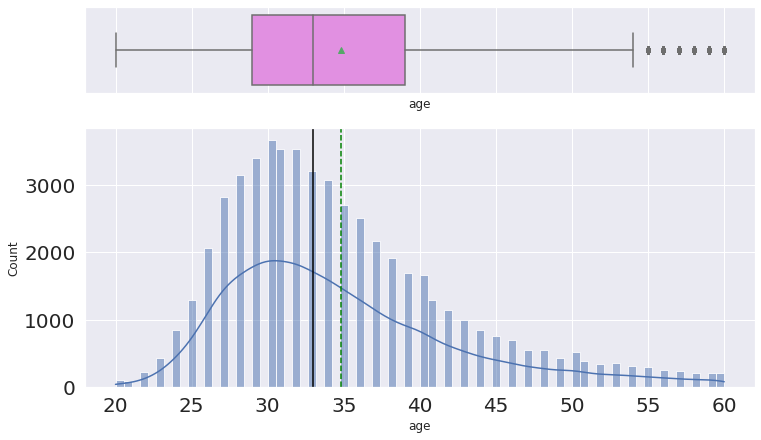

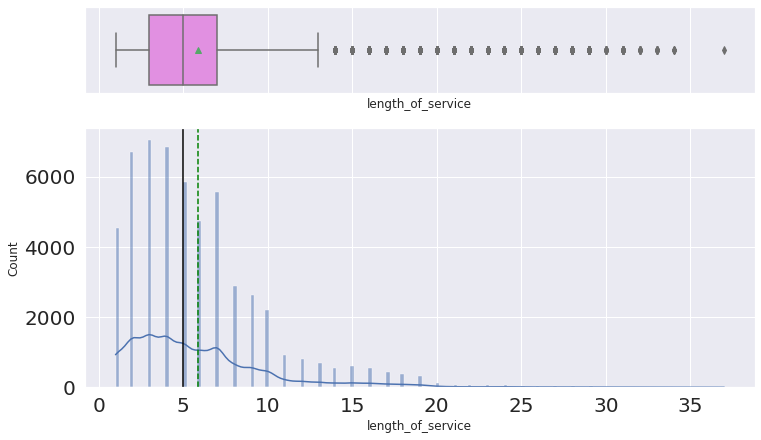

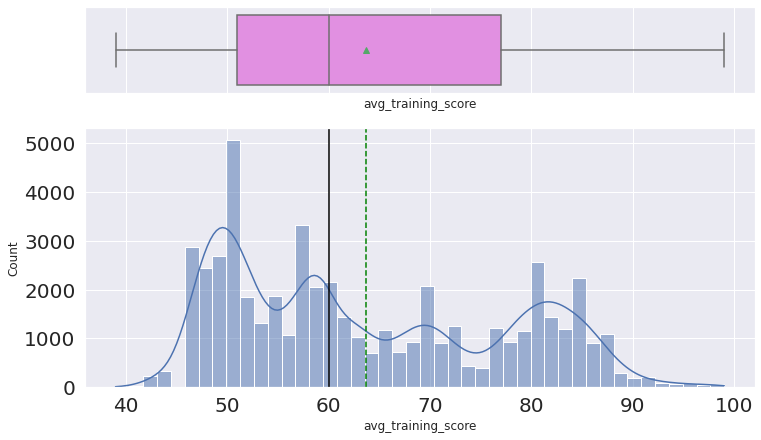

In [20]:
for col in data.columns:
  if data[col].dtype not in ["object", "category"]:
    histogram_boxplot(data, col, kde=True)

##### Observations:
* Age is slightly right-skewed and has some outliers
* Length of service is right-skewed and has a lot of outliers
* Avg traning score is evenly distributed but has multiple bumps


#### Categorical columns

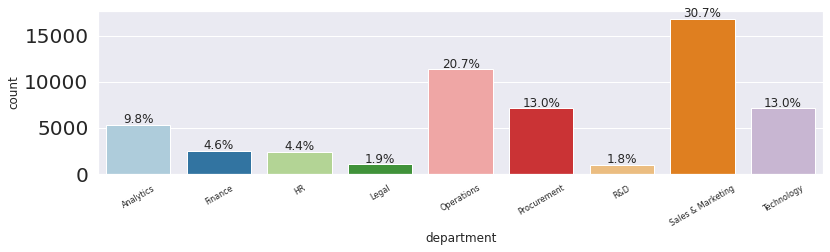

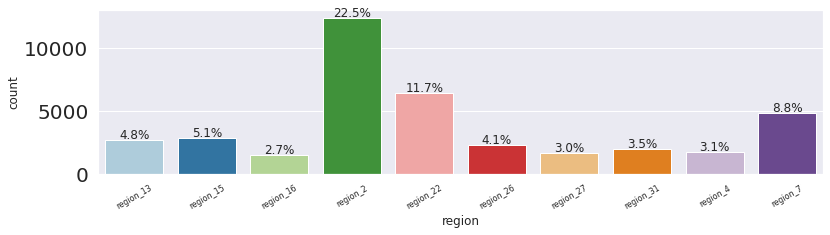

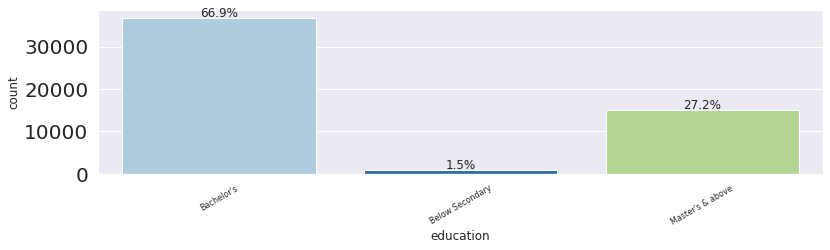

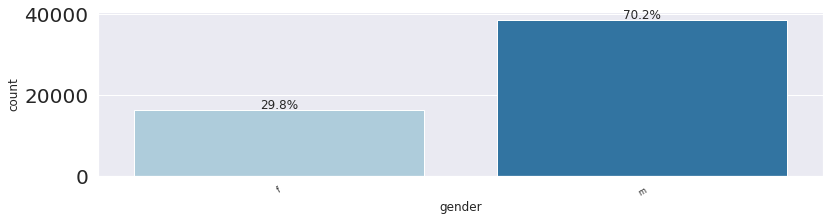

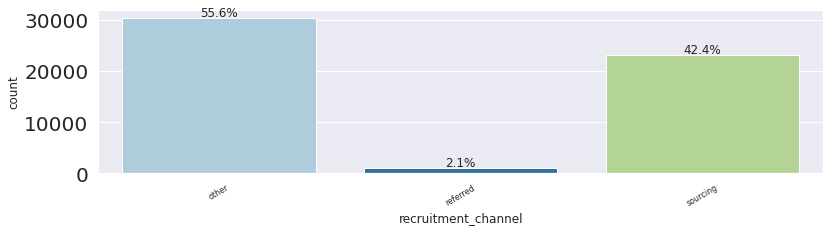

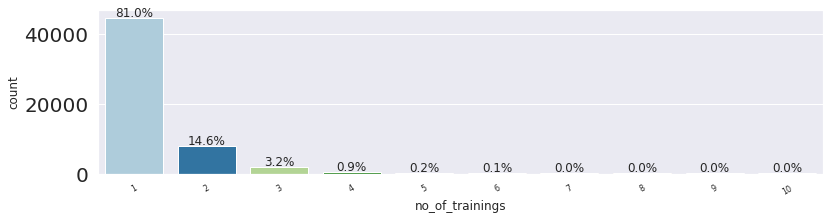

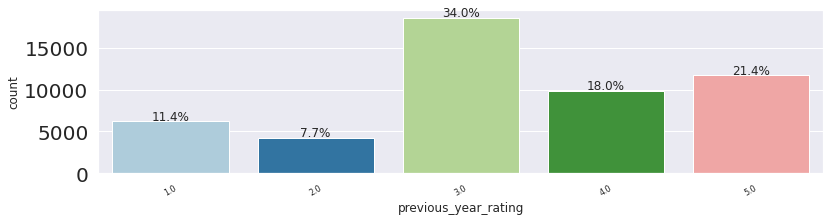

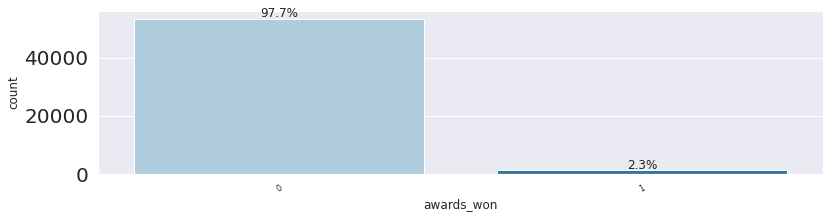

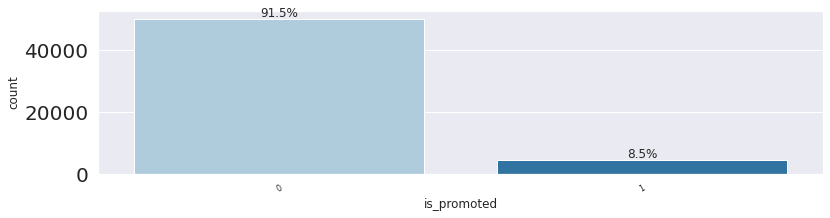

In [21]:
for col in data.columns:
  if data[col].dtype in ["object", "category"]:
    labeled_barplot(data, col, perc=True, n=10)

##### Observations:
* Only 8.5% eemployees are recommended for promotion
* Only 2.3% employees have won awards in last year
* 41.5% employeees have ratigns 3 in the previous year.
* Nearly 40% employees have above average rating in previous year
* Nearly 19% employees have bellow averagee rating in previous year
* Most employees have done only one trainig in last year. A few have done 2 and less than 2% employeees have done more than 3 trainings
* 55.6% employes are rccruited from other chanels, 42.4% from sourcing and only 2.1% are reffereed
* over 70% employees are Male
* 66.9% employees have Bachlelor's and 27.2% have masters level education
* Most of the employees are from region 2 or rgion 22
* Sales and Marketing has most number of employees followed by Operations and then technology.

### Bivariate Analysis

#### Correlation plot
Lets take a look at the correlations between the non-categorical columns

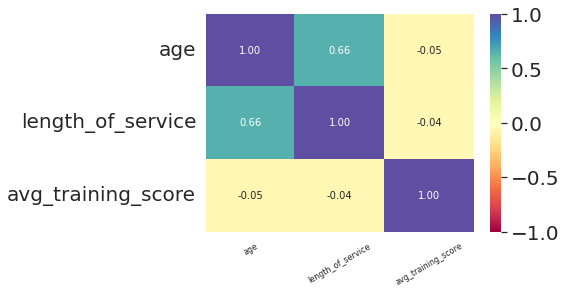

In [22]:
from numpy.ma.core import size
plt.figure()
sns.heatmap(
    data.corr(), 
    annot=True,
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
)
plt.xticks(rotation=30, fontsize=8)
plt.show()

##### Observation:
* Age and lngth of seervice are correleated to some extent but not enough to drop one of th columns

#### Pairplot

<Figure size 432x288 with 0 Axes>

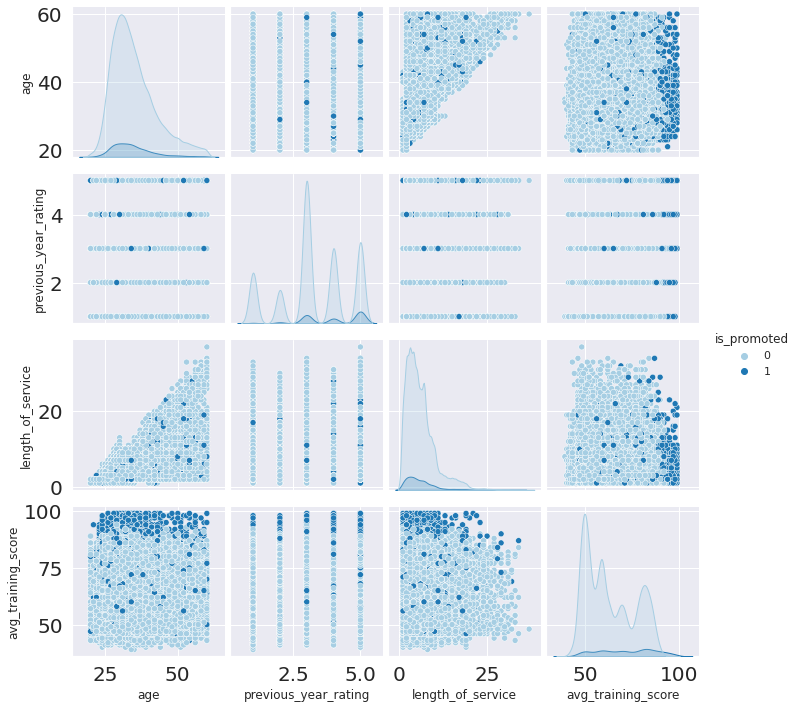

In [23]:
plt.figure()
sns.pairplot(
    data=data, 
    diag_kind="kde",
    palette="Paired",
    hue="is_promoted"
)
plt.show()

##### Obserrvations:
* More employees with higher average traning scores are promoted
* More employees with length of service less than 20 are promoted
* Most of the promoted eemployees are between the age of 20 to 45

#### Categorical columns vs target
Let's check the relation of the categorical columns with the target

is_promoted            0     1    All
department                           
All                50140  4668  54808
Sales & Marketing  15627  1213  16840
Operations         10325  1023  11348
Technology          6370   768   7138
Procurement         6450   688   7138
Analytics           4840   512   5352
Finance             2330   206   2536
HR                  2282   136   2418
R&D                  930    69    999
Legal                986    53   1039
---------------------------------------------------------------------------


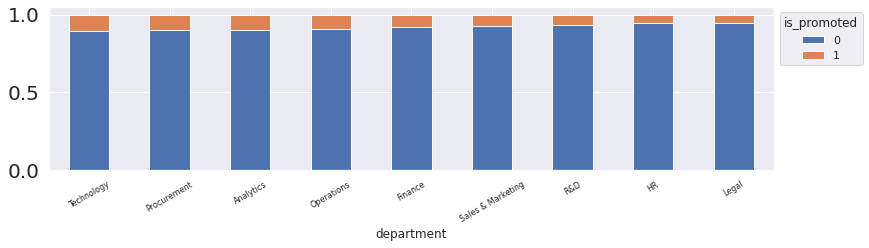

is_promoted      0     1    All
region                         
All          50140  4668  54808
region_2     11354   989  12343
region_22     5694   734   6428
region_7      4327   516   4843
region_4      1457   246   1703
region_13     2418   230   2648
region_15     2586   222   2808
region_28     1164   154   1318
region_26     2117   143   2260
region_23     1038   137   1175
region_27     1528   131   1659
region_31     1825   110   1935
region_17      687   109    796
region_25      716   103    819
region_16     1363   102   1465
region_11     1241    74   1315
region_14      765    62    827
region_30      598    59    657
region_1       552    58    610
region_19      821    53    874
region_8       602    53    655
region_10      597    51    648
region_20      801    49    850
region_29      951    43    994
region_32      905    40    945
region_3       309    37    346
region_5       731    35    766
region_12      467    33    500
region_6       658    32    690
region_2

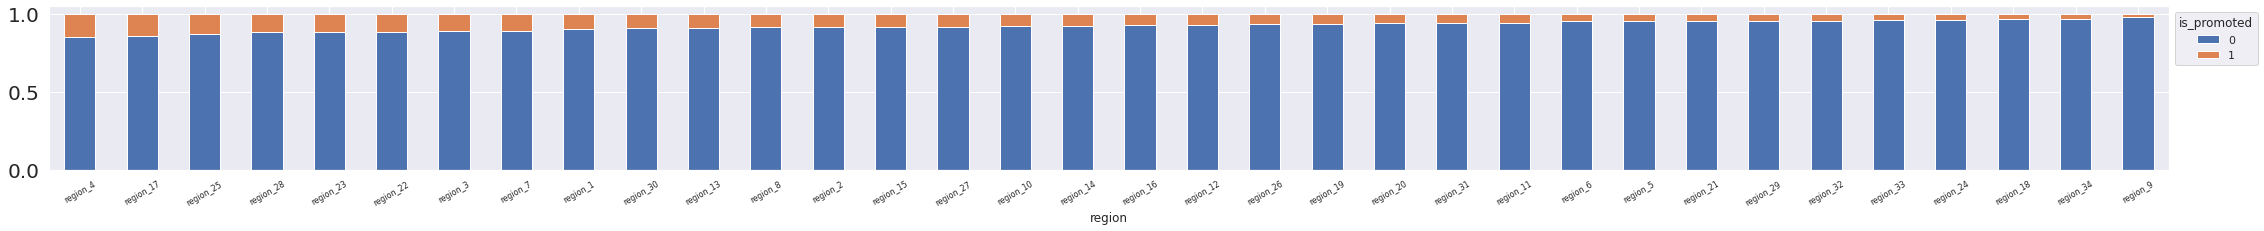

is_promoted           0     1    All
education                           
All               47853  4546  52399
Bachelor's        33661  3008  36669
Master's & above  13454  1471  14925
Below Secondary     738    67    805
---------------------------------------------------------------------------


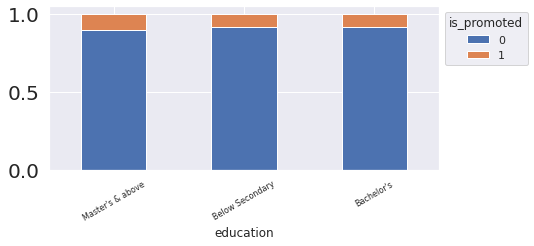

is_promoted      0     1    All
gender                         
All          50140  4668  54808
m            35295  3201  38496
f            14845  1467  16312
---------------------------------------------------------------------------


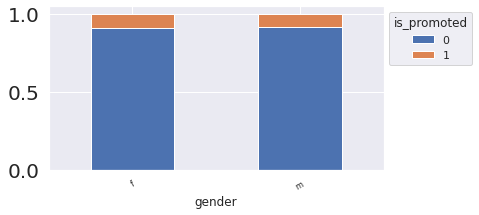

is_promoted              0     1    All
recruitment_channel                    
All                  50140  4668  54808
other                27890  2556  30446
sourcing             21246  1974  23220
referred              1004   138   1142
---------------------------------------------------------------------------


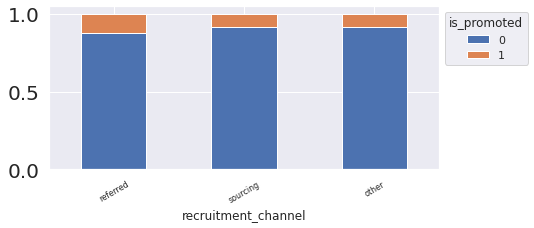

is_promoted          0     1    All
no_of_trainings                    
All              50140  4668  54808
1                40468  3910  44378
2                 7382   605   7987
3                 1654   122   1776
4                  442    26    468
5                  125     3    128
6                   42     2     44
7                   12     0     12
8                    5     0      5
9                    5     0      5
10                   5     0      5
---------------------------------------------------------------------------


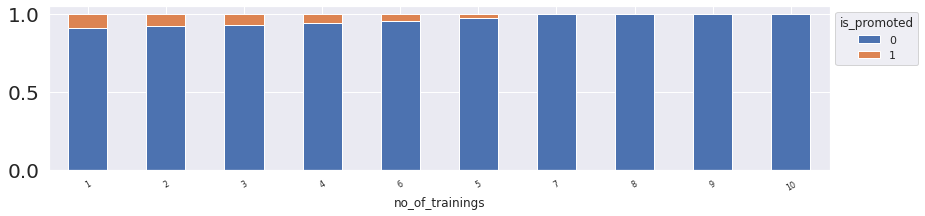

is_promoted               0     1    All
previous_year_rating                    
All                   46355  4329  50684
5.0                    9820  1921  11741
3.0                   17263  1355  18618
4.0                    9093   784   9877
2.0                    4044   181   4225
1.0                    6135    88   6223
---------------------------------------------------------------------------


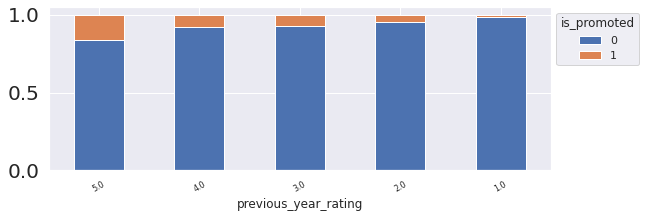

is_promoted      0     1    All
awards_won                     
All          50140  4668  54808
0            49429  4109  53538
1              711   559   1270
---------------------------------------------------------------------------


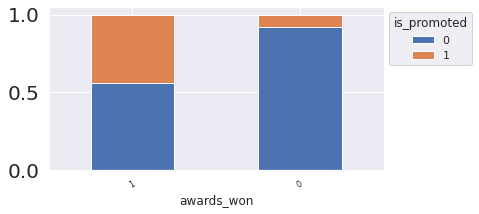

In [24]:
from inspect import stack
for col in data.columns:
  if col == "is_promoted":
    continue
  if data[col].dtype in ["object", "category"]:
    stacked_barplot(data, col, "is_promoted")

##### Observations:
* Employees from all the departments are promotted. Department does not seem to influence the target
* Though employees from all the regions are promoted, more percentage of employees from regionn 4 are promoted compared to region 9
* Employees with all the educatio level are promoted in equal percetage. Education does not seem to affect the target 
* Both male and female employees arre promotted in equal ratios. Gender does not seem to affect the target 
* Recruitment channel as well does not seem to affect the target 
* Employees with only one training are promoted more. Number of trainiings seems to negatively affect the chances of being promoted
* Previous year's reatings have a clear impact on promotion. Higher the ratings higher are the chances of promotion. 
* Winning an award increases the chances of promotion

## Data Preprocessing

### Data split
Let's now split the data into training, validation and test datasets

In [25]:
# lets create a copy before spliting
data1 = data.copy()

In [26]:
# lets separate the target from the rest of the data
X = data1.drop(["is_promoted"], axis=1)
y = data1["is_promoted"]

In [27]:
# split into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# split temp into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)

In [28]:
# Let's compare the target data after OverSampling
print("-"*30)
print("y_train")
print("-"*30)
print(y_train.value_counts())
print("-"*30)
print("y_val")
print("-"*30)
print(y_val.value_counts())
print("-"*30)
print("y_test")
print("-"*30)
print(y_test.value_counts())

------------------------------
y_train
------------------------------
0    30084
1     2800
Name: is_promoted, dtype: int64
------------------------------
y_val
------------------------------
0    10028
1      934
Name: is_promoted, dtype: int64
------------------------------
y_test
------------------------------
0    10028
1      934
Name: is_promoted, dtype: int64


### Missing value treatment


*previous_year_rating* is of type float64. But it has some Null values so we will have to treat those first before converting to category.

In [29]:
# fill null values with the median
med_imputer = SimpleImputer(strategy="median")

# Fit and transform the train data
X_train[["previous_year_rating"]] = med_imputer.fit_transform(
    X_train[["previous_year_rating"]]
)

# transform the val and test data
X_val[["previous_year_rating"]] = med_imputer.transform(
    X_val[["previous_year_rating"]]
)

X_test[["previous_year_rating"]] = med_imputer.transform(
    X_test[["previous_year_rating"]]
)

In [30]:
X_train["previous_year_rating"] = X_train["previous_year_rating"].astype("category")
X_val["previous_year_rating"] = X_val["previous_year_rating"].astype("category")
X_test["previous_year_rating"] = X_test["previous_year_rating"].astype("category")

*avg_training_score* has null values. For this column instead of plainly imputing nulls with median, lets group by the number of trainings and then impute null with median of each group.

In [31]:
trainings_df = X_train[["no_of_trainings", "avg_training_score"]]
trainings_grps = trainings_df.groupby("no_of_trainings").median().reset_index()

def get_avg_training_score(row):
  if pd.isna(row["avg_training_score"]):
    avg_score = trainings_grps[
      trainings_grps["no_of_trainings"] == row["no_of_trainings"]
    ]["avg_training_score"]
  else:
    avg_score = row["avg_training_score"]
  return int(avg_score)

X_train["avg_training_score"] = X_train.apply(get_avg_training_score, axis=1)
X_val["avg_training_score"] = X_val.apply(get_avg_training_score, axis=1)
X_test["avg_training_score"] = X_test.apply(get_avg_training_score, axis=1)

*education* has null values. lets impute this with most_frequent values

In [32]:
mf_imputer = SimpleImputer(strategy="most_frequent")

# Fit and transform the train data
X_train[["education"]] = mf_imputer.fit_transform(
    X_train[["education"]]
)

# transform the val and test data
X_val[["education"]] = mf_imputer.transform(
    X_val[["education"]]
)

X_test[["education"]] = mf_imputer.transform(
    X_test[["education"]]
)

In [33]:
# Checking that no column has missing values in train or test sets
print("-" * 30)
print("nulls in X_train")
print("-" * 30)
print(X_train.isna().sum())
print("-" * 30)
print("nulls in X_val")
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print("nulls in X_test")
print("-" * 30)
print(X_test.isna().sum())

------------------------------
nulls in X_train
------------------------------
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won              0
avg_training_score      0
dtype: int64
------------------------------
nulls in X_val
------------------------------
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won              0
avg_training_score      0
dtype: int64
------------------------------
nulls in X_test
------------------------------
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age         

#### Encoding categorical variables
Let's now convert the categorical ad object variables into dummies

In [34]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_val.shape, X_test.shape)

(32884, 63) (10962, 63) (10962, 63)


## Model Building

### Model Evaluation Criteria
For the model we are building, it will be important to identify the employees to be promoted.

At the same time it is importat for the company that the employees who need more time to work in their skills are not yet promoted.

Because of this, *we will be using **accuracy** as a metric for our model performance*.

In [35]:
## Function to create confusion matrix
def make_confusion_matrix(model, X_actual, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_actual)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - 0", "Actual - 1"]],
        columns=[i for i in ["Predicted - 0", "Predicted - 1"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [36]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(
    model_name, 
    model, 
    X_train_set,
    Y_train_set,
    X_val_set,
    Y_val_set,
    X_test_set,
    Y_test_set,
    print_scores=False,
    scores = ["Accuracy"]
):
    """
    model : classifier to predict values of X

    """
    scores = [s.title() for s in scores]        
    
    # defining an empty list to store train and test results
    score_dict = {"Model Name": model_name}

    # Predicting on train and tests
    pred_train = model.predict(X_train_set)
    pred_val = model.predict(X_val_set)
    pred_test = model.predict(X_test_set)
    
    if "Accuracy" in scores:
        # Accuracy of the model
        train_acc = model.score(X_train_set, Y_train_set)
        score_dict["Train_Accuracy"] = train_acc

        val_acc = model.score(X_val_set, Y_val_set)
        score_dict["Val_Accuracy"] = val_acc

        test_acc = model.score(X_test_set, Y_test_set)
        score_dict["Test_Accuracy"] = test_acc

    if "Recall" in scores:
        # Recall of the model
        train_recall = metrics.recall_score(Y_train_set, pred_train)
        score_dict["Train_Recall"] = train_recall

        val_recall = metrics.recall_score(Y_val_set, pred_val)
        score_dict["Val_Recall"] = val_recall

        test_recall = metrics.recall_score(Y_test_set, pred_test)
        score_dict["Test_Recall"] = test_recall
    
    if "Precision" in scores:
        # Precision of the model
        train_precision = metrics.precision_score(Y_train_set, pred_train)
        score_dict["Train_Precision"] = train_precision

        val_precision = metrics.precision_score(Y_val_set, pred_val)
        score_dict["Val_Precision"] = val_precision

        test_precision = metrics.precision_score(Y_test_set, pred_test)
        score_dict["Test_Precision"] = test_precision
    
    if "F1" in scores:
        # F1 score of the model
        train_f1 = metrics.f1_score(Y_train_set, pred_train)
        score_dict["Train_F1"] = train_f1

        val_f1 = metrics.f1_score(Y_val_set, pred_val)
        score_dict["Val_F1"] = val_f1

        test_f1 = metrics.f1_score(Y_test_set, pred_test)
        score_dict["Test_F1"] = test_f1

    # If the flag is set to True then only the following print statements will be dispayed.
    # The default value is set to False.
    if print_scores == True:
        print(json.dumps(score_dict, indent=4))

    return score_dict  # returning the dict with train and test scores

### Models With Original Data
Let's first build models with the original data

In [37]:
# We will be storing the scores for various models in the following lists
score_list = []         # list to store the scores of each models
results = {}            # dictionary to store the cross-validation scores
models = []             # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results[name] = cv_result
    print("{}: {}".format(name, cv_result.mean() * 100))

for name, model in models:
    model.fit(X_train, y_train)
    scores = get_metrics_score(
        name,
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test,
        y_test,
    )
    score_list.append(scores)


Cross-Validation Performance:

Bagging: 92.9844367509425
Random forest: 92.7654799202559
GBM: 93.53180940585176
Adaboost: 92.56781401455414
Xgboost: 93.49836181680094
dtree: 88.34084541092288


In [38]:
pd.DataFrame(score_list) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy
Model Name,,,
GBM,0.936474,0.936234,0.936143
Xgboost,0.935896,0.935869,0.935869
Bagging,0.987897,0.930305,0.931308
Random forest,0.999605,0.927842,0.929210
Adaboost,0.925952,0.924284,0.926200
dtree,0.999696,0.880952,0.881409


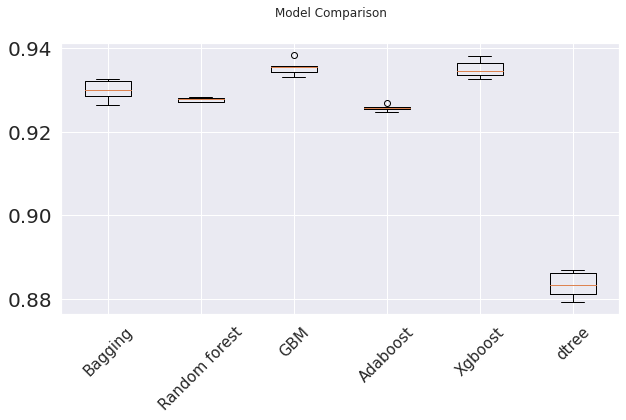

In [39]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results.values())
ax.set_xticklabels(results.keys())
plt.xticks(rotation=45, fontsize=15)
plt.show()

#### Obsrvations:
* Among the models with original data, ***GBM (GradientBoostingClassifier)*** Model is getting best Accuracy of ***94%***.
* This model is genneralized as well getting almost similar scores on the training, Validation and Testing data
* ***XGBoost*** model as well got ***94%*** accuracy and is ***most generalized***
*DecisionTree, Random Forest and Bagging models are slightly overfitting

### Models with OverSampled Data
Let's build the same models with OverSampled data

In [40]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [41]:
# Let's compare the target data after OverSampling
print("-"*30)
print("ORGINAL DATA")
print("-"*30)
print(y_train.value_counts())
print("-"*30)
print("OVERSAMPLED DATA")
print("-"*30)
print(y_train_over.value_counts())

------------------------------
ORGINAL DATA
------------------------------
0    30084
1     2800
Name: is_promoted, dtype: int64
------------------------------
OVERSAMPLED DATA
------------------------------
0    30084
1    30084
Name: is_promoted, dtype: int64


In [42]:
# build models with SMOTE data
score_list_SMOTE = []         # list to store the scores of each models
results_SMOTE = {}            # dictionary to store the cross-validation scores
models_SMOTE = []
# Appending models into the list
models_SMOTE.append(("Bagging_SMOTE", BaggingClassifier(random_state=1)))
models_SMOTE.append(("Random forest_SMOTE", RandomForestClassifier(random_state=1)))
models_SMOTE.append(("GBM_SMOTE", GradientBoostingClassifier(random_state=1)))
models_SMOTE.append(("Adaboost_SMOTE", AdaBoostClassifier(random_state=1)))
models_SMOTE.append(
    ("Xgboost_SMOTE", XGBClassifier(random_state=1, eval_metric="logloss"))
)
models_SMOTE.append(("dtree_SMOTE", DecisionTreeClassifier(random_state=1)))

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models_SMOTE:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, 
        X=X_train_over, 
        y=y_train_over, 
        scoring=scoring, 
        cv=kfold
    )
    results_SMOTE[name] = cv_result
    print("{}: {}".format(name, cv_result.mean() * 100))

for name, model in models_SMOTE:
    model.fit(X_train_over, y_train_over)
    scores = get_metrics_score(
        name,
        model,
        X_train_over,
        y_train_over,
        X_val,
        y_val,
        X_test,
        y_test,
    )
    score_list_SMOTE.append(scores)


Cross-Validation Performance:

Bagging_SMOTE: 93.59958800352379
Random forest_SMOTE: 94.50039812818224
GBM_SMOTE: 85.76484718544692
Adaboost_SMOTE: 87.1393376540921
Xgboost_SMOTE: 85.32276102774874
dtree_SMOTE: 91.083305050494


In [43]:
pd.DataFrame(score_list_SMOTE) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy
Model Name,,,
Random forest_SMOTE,0.999368,0.902116,0.899562
Bagging_SMOTE,0.994316,0.887885,0.884419
dtree_SMOTE,0.999368,0.845466,0.844919
GBM_SMOTE,0.861039,0.837621,0.832330
Adaboost_SMOTE,0.872391,0.831235,0.825123
Xgboost_SMOTE,0.852862,0.827860,0.821474


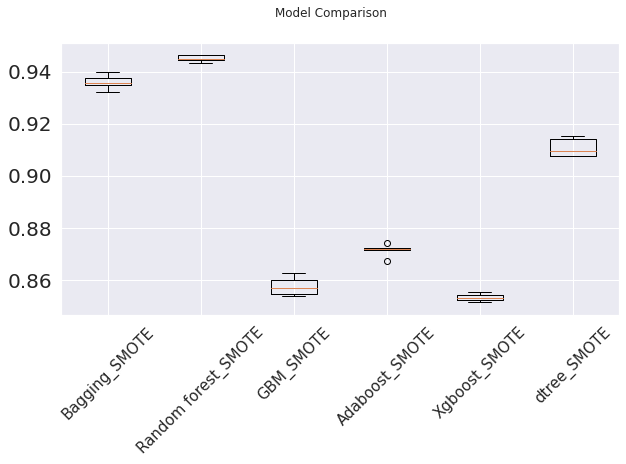

In [44]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results_SMOTE.values())
ax.set_xticklabels(results_SMOTE.keys())
plt.xticks(rotation=45, fontsize=15)
plt.show()

#### Observctions:
* Oversampling reduced the validation and Test Accuracy
* Best acccuracy with the Oversampled data is for the Random Forest Model but it still continues to be slightly overfitting.
* Best acccuracy with oversampled data is lower thann the model with original data

### Models with Undersampled Data
Let's now try to build models with undersampled data

In [45]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [46]:
# Let's compare the target data after OverSampling
print("-"*30)
print("ORGINAL DATA")
print("-"*30)
print(y_train.value_counts())
print("-"*30)
print("UNDERSAMPLED DATA")
print("-"*30)
print(y_train_un.value_counts())

------------------------------
ORGINAL DATA
------------------------------
0    30084
1     2800
Name: is_promoted, dtype: int64
------------------------------
UNDERSAMPLED DATA
------------------------------
0    2800
1    2800
Name: is_promoted, dtype: int64


In [47]:
# build models with RUS data
score_list_RUS = []         # list to store the scores of each models
results_RUS = {}            # dictionary to store the cross-validation scores
models_RUS = []
# Appending models into the list
models_RUS.append(("Bagging_RUS", BaggingClassifier(random_state=1)))
models_RUS.append(("Random forest_RUS", RandomForestClassifier(random_state=1)))
models_RUS.append(("GBM_RUS", GradientBoostingClassifier(random_state=1)))
models_RUS.append(("Adaboost_RUS", AdaBoostClassifier(random_state=1)))
models_RUS.append(
    ("Xgboost_RUS", XGBClassifier(random_state=1, eval_metric="logloss"))
)
models_RUS.append(("dtree_RUS", DecisionTreeClassifier(random_state=1)))

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models_RUS:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, 
        X=X_train_un, 
        y=y_train_un, 
        scoring=scoring, 
        cv=kfold
    )
    results_RUS[name] = cv_result
    print("{}: {}".format(name, cv_result.mean() * 100))

for name, model in models_RUS:
    model.fit(X_train_un, y_train_un)
    scores = get_metrics_score(
        name,
        model,
        X_train_un,
        y_train_un,
        X_val,
        y_val,
        X_test,
        y_test,
    )
    score_list_RUS.append(scores)


Cross-Validation Performance:

Bagging_RUS: 69.19642857142857
Random forest_RUS: 69.80357142857143
GBM_RUS: 71.41071428571429
Adaboost_RUS: 69.91071428571428
Xgboost_RUS: 71.53571428571428
dtree_RUS: 64.57142857142857


In [48]:
pd.DataFrame(score_list_RUS) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy
Model Name,,,
Xgboost_RUS,0.736786,0.815910,0.815727
GBM_RUS,0.741964,0.811987,0.809889
Adaboost_RUS,0.710179,0.763820,0.767926
Bagging_RUS,0.979643,0.749133,0.745667
Random forest_RUS,0.999821,0.737183,0.739372
dtree_RUS,0.999821,0.642675,0.643404


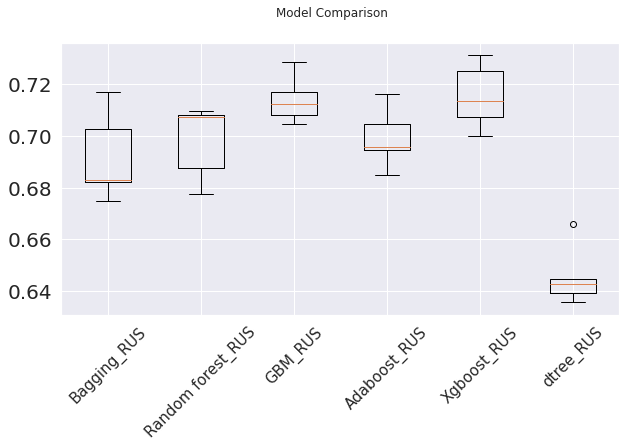

In [49]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results_RUS.values())
ax.set_xticklabels(results_RUS.keys())
plt.xticks(rotation=45, fontsize=15)
plt.show()

#### Observations:
* Undersampling has reduced the Accuuracy onn test and Validation data even further
* Best Test Accuracy with undersampling is lower than the worst Accuracy uing Oversampled data

#### Confusion Matrix
Let's plot the confusion matrix for the top two models till now

In [50]:
# let's once more look at the actual distribution of the target
y_test.value_counts()

0    10028
1      934
Name: is_promoted, dtype: int64

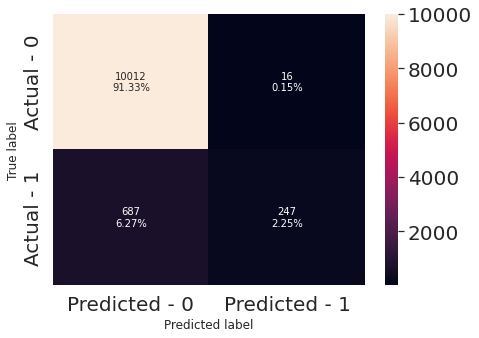

In [51]:
Xgboost = None
for name, model in models:
    if name == "Xgboost":
        Xgboost = model
make_confusion_matrix(Xgboost, X_test, y_test)

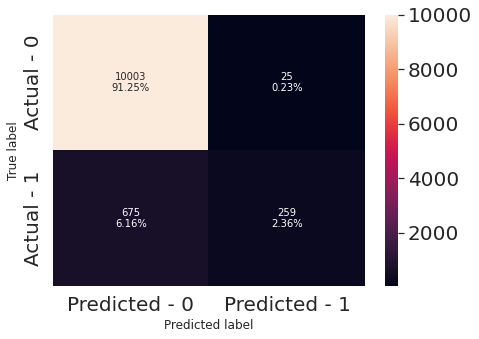

In [52]:
gbm = None
for name, model in models:
    if name == "GBM":
        gbm = model
make_confusion_matrix(gbm, X_test, y_test)

#### Observations:
Both *Xgboost* and *GBM* models are able to correctly predict the 0 values but not doing so well at predicting the 1s

### Model Tunning
Till now we have created the Base models using Original, OverSampled and Undersampled data.

Among the base models, we got the best accuracy with the GBM and XGBoost models using the original data.

Let's now try to tune these models to see if we can improve the model performance.

In [53]:
# we will use this list to store the performance of the tuned models
score_list_tuned = []

Because we noticed that the Accuracy on the base models is good but the F1-Score needs improvement, ***we will be using multi_scoring with both Accuracy and F1-Score while tuning the models***

We will then refit the model for F1-Score

In [54]:
# Type of scoring used to compare parameter combinations
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
recall_scorer = metrics.make_scorer(metrics.recall_score)
scoring = {
    "Accuracy": accuracy_scorer,
    # "Recall": recall_scorer, 
    "F1": "f1"
}

#### Tuning XGboost Model with original data

Lets use *RandomizedSearchCV* to find the the best parameters for tuning the XGBoost model using the original data

In [55]:
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={
    "n_estimators": np.arange(50, 300, 50),
    "scale_pos_weight": [0, 1, 2, 5, 10],
    "learning_rate": [0.01,0.1,0.2,0.05], 
    "gamma": [0,1,3,5],
    "subsample": [0.7,0.8,0.9,1]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",      # refitting for F1-Sacore
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 2, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 1}with CV score=0.4840345918231101


In [56]:
tuned_xgb_original = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=2,
    n_estimators=200,
    learning_rate=0.2,
    gamma=1,
)
tuned_xgb_original.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', gamma=1, learning_rate=0.2,
              n_estimators=200, random_state=1, scale_pos_weight=2,
              subsample=0.8)

In [57]:
xgb_tuned_org_scores = get_metrics_score(
        "XGboost_tuned_original",
        tuned_xgb_original,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(xgb_tuned_org_scores)

In [58]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
XGboost_tuned_original,0.940731,0.937603,0.938424,0.3675,0.356531,0.368308,0.513601,0.493333,0.504769


#### Tuning XGboost Model with OverSampled data

In [59]:
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={
    "n_estimators": np.arange(50, 300, 50),
    "scale_pos_weight": [0, 1, 2, 5, 10],
    "learning_rate": [0.01,0.1,0.2,0.05], 
    "gamma": [0,1,3,5],
    "subsample": [0.7,0.8,0.9,1]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",      # refitting for F1-Score
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 1, 'scale_pos_weight': 1, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 5}with CV score=0.8981594015247346


In [60]:
tuned_xgb_over = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=1,
    scale_pos_weight=1,
    n_estimators=250,
    learning_rate=0.2,
    gamma=5,
)
tuned_xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(eval_metric='logloss', gamma=5, learning_rate=0.2,
              n_estimators=250, random_state=1)

In [61]:
xgb_tuned_over_scores = get_metrics_score(
        "XGboost_tuned_over",
        tuned_xgb_over,
        X_train_over,
        y_train_over,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(xgb_tuned_over_scores)

In [62]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
XGboost_tuned_original,0.940731,0.937603,0.938424,0.367500,0.356531,0.368308,0.513601,0.493333,0.504769
XGboost_tuned_over,0.913858,0.895548,0.897738,0.876778,0.328694,0.334047,0.910541,0.349062,0.357593


#### Tuning XGboost Model with UnderSampled data

In [63]:
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={
    "n_estimators": np.arange(50, 300, 50),
    "scale_pos_weight": [0, 1, 2, 5, 10],
    "learning_rate": [0.01,0.1,0.2,0.05], 
    "gamma": [0,1,3,5],
    "subsample": [0.7,0.8,0.9,1]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",      # refitting for F1-Score
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 0.7, 'scale_pos_weight': 2, 'n_estimators': 150, 'learning_rate': 0.2, 'gamma': 0}with CV score=0.7238439573374678


In [64]:
tuned_xgb_un = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.7,
    scale_pos_weight=2,
    n_estimators=150,
    learning_rate=0.2,
    gamma=0,
)
tuned_xgb_un.fit(X_train_un, y_train_un)

XGBClassifier(eval_metric='logloss', learning_rate=0.2, n_estimators=150,
              random_state=1, scale_pos_weight=2, subsample=0.7)

In [65]:
xgb_tuned_under_scores = get_metrics_score(
        "XGboost_tuned_under",
        tuned_xgb_un,
        X_train_un,
        y_train_un,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(xgb_tuned_under_scores)

In [66]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
XGboost_tuned_original,0.940731,0.937603,0.938424,0.367500,0.356531,0.368308,0.513601,0.493333,0.504769
XGboost_tuned_over,0.913858,0.895548,0.897738,0.876778,0.328694,0.334047,0.910541,0.349062,0.357593
XGboost_tuned_under,0.746429,0.552910,0.548531,0.907143,0.845824,0.860814,0.781538,0.243790,0.245234


#### Tuning Gradient Boost Model with original data

In [67]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [
        AdaBoostClassifier(random_state=1),
        DecisionTreeClassifier(random_state=1)
    ],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",      # refitting for F1-Sacore
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)}with CV score=0.4513319976702047


In [68]:
tuned_gbm_original = GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators=125,
    max_features=0.7,
    learning_rate=0.2,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm_original.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [69]:
tuned_gbm_org_scores = get_metrics_score(
        "GBM_tuned_original",
        tuned_gbm_original,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(tuned_gbm_org_scores)

In [70]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
GBM_tuned_original,0.941096,0.939062,0.939883,0.325000,0.311563,0.320128,0.484429,0.465600,0.475736
XGboost_tuned_original,0.940731,0.937603,0.938424,0.367500,0.356531,0.368308,0.513601,0.493333,0.504769
XGboost_tuned_over,0.913858,0.895548,0.897738,0.876778,0.328694,0.334047,0.910541,0.349062,0.357593
XGboost_tuned_under,0.746429,0.552910,0.548531,0.907143,0.845824,0.860814,0.781538,0.243790,0.245234


#### Tuning Gradient Boost Model with OverSampled data

In [73]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [
        AdaBoostClassifier(random_state=1),
        DecisionTreeClassifier(random_state=1)
    ],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",      # refitting for F1-Sacore
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 1, 'n_estimators': 125, 'max_features': 1, 'learning_rate': 1, 'init': DecisionTreeClassifier(random_state=1)}with CV score=0.9067411257517708


In [74]:
tuned_gbm_over = GradientBoostingClassifier(
    random_state=1,
    subsample=1,
    n_estimators=125,
    max_features=1,
    learning_rate=1,
    init=DecisionTreeClassifier(random_state=1),
)
tuned_gbm_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(init=DecisionTreeClassifier(random_state=1),
                           learning_rate=1, max_features=1, n_estimators=125,
                           random_state=1, subsample=1)

In [75]:
tuned_gbm_over_scores = get_metrics_score(
        "GBM_tuned_over",
        tuned_gbm_over,
        X_train_over,
        y_train_over,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(tuned_gbm_over_scores)

In [76]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
GBM_tuned_original,0.941096,0.939062,0.939883,0.325000,0.311563,0.320128,0.484429,0.465600,0.475736
XGboost_tuned_original,0.940731,0.937603,0.938424,0.367500,0.356531,0.368308,0.513601,0.493333,0.504769
XGboost_tuned_over,0.913858,0.895548,0.897738,0.876778,0.328694,0.334047,0.910541,0.349062,0.357593
GBM_tuned_over,0.999368,0.845192,0.844919,0.999767,0.377944,0.361884,0.999369,0.293799,0.284512
XGboost_tuned_under,0.746429,0.552910,0.548531,0.907143,0.845824,0.860814,0.781538,0.243790,0.245234


#### Tuning Gradient Boost Model with UnderSampled data

In [77]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [
        AdaBoostClassifier(random_state=1),
        DecisionTreeClassifier(random_state=1)
    ],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs = -1, 
    scoring=scoring,     # use multi_scoring
    refit="F1",          # refitting for F1-Sacore
    cv=5, 
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    f"Best parameters are {randomized_cv.best_params_}"
    f"with CV score={randomized_cv.best_score_}"
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)}with CV score=0.6982871335964428


In [78]:
tuned_gbm_under = GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators=125,
    max_features=0.7,
    learning_rate=0.2,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm_under.fit(X_train_un, y_train_un)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [79]:
tuned_gbm_under_scores = get_metrics_score(
        "GBM_tuned_under",
        tuned_gbm_under,
        X_train_un,
        y_train_un,
        X_val,
        y_val,
        X_test,
        y_test,
        scores=["Accuracy", "Recall", "F1"]
    )
score_list_tuned.append(tuned_gbm_under_scores)

In [82]:
pd.DataFrame(score_list_tuned) \
    .set_index("Model Name") \
    .sort_values(by="Val_Accuracy", ascending=False)

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Recall,Val_Recall,Test_Recall,Train_F1,Val_F1,Test_F1
Model Name,,,,,,,,,
GBM_tuned_original,0.941096,0.939062,0.939883,0.325000,0.311563,0.320128,0.484429,0.465600,0.475736
XGboost_tuned_original,0.940731,0.937603,0.938424,0.367500,0.356531,0.368308,0.513601,0.493333,0.504769
XGboost_tuned_over,0.913858,0.895548,0.897738,0.876778,0.328694,0.334047,0.910541,0.349062,0.357593
GBM_tuned_over,0.999368,0.845192,0.844919,0.999767,0.377944,0.361884,0.999369,0.293799,0.284512
GBM_tuned_under,0.772500,0.780241,0.775680,0.713929,0.654176,0.665953,0.758346,0.336546,0.335944
XGboost_tuned_under,0.746429,0.552910,0.548531,0.907143,0.845824,0.860814,0.781538,0.243790,0.245234


### Best Model
* GBM_tuned_original has the best Accuracy scores
* GBM_tuned_original and XGboost_tuned_original models have almost simlar Accuracies
* XGboost_tuned_original model looks most generalized. For this model Accuracy, Recall and F1-Soce values not varying much between the training and test datasets 

***XGboost_tuned_original*** can be considered the best model built for this excercise

Lets take a look at the most important featuress of XGboost_tuned_original model

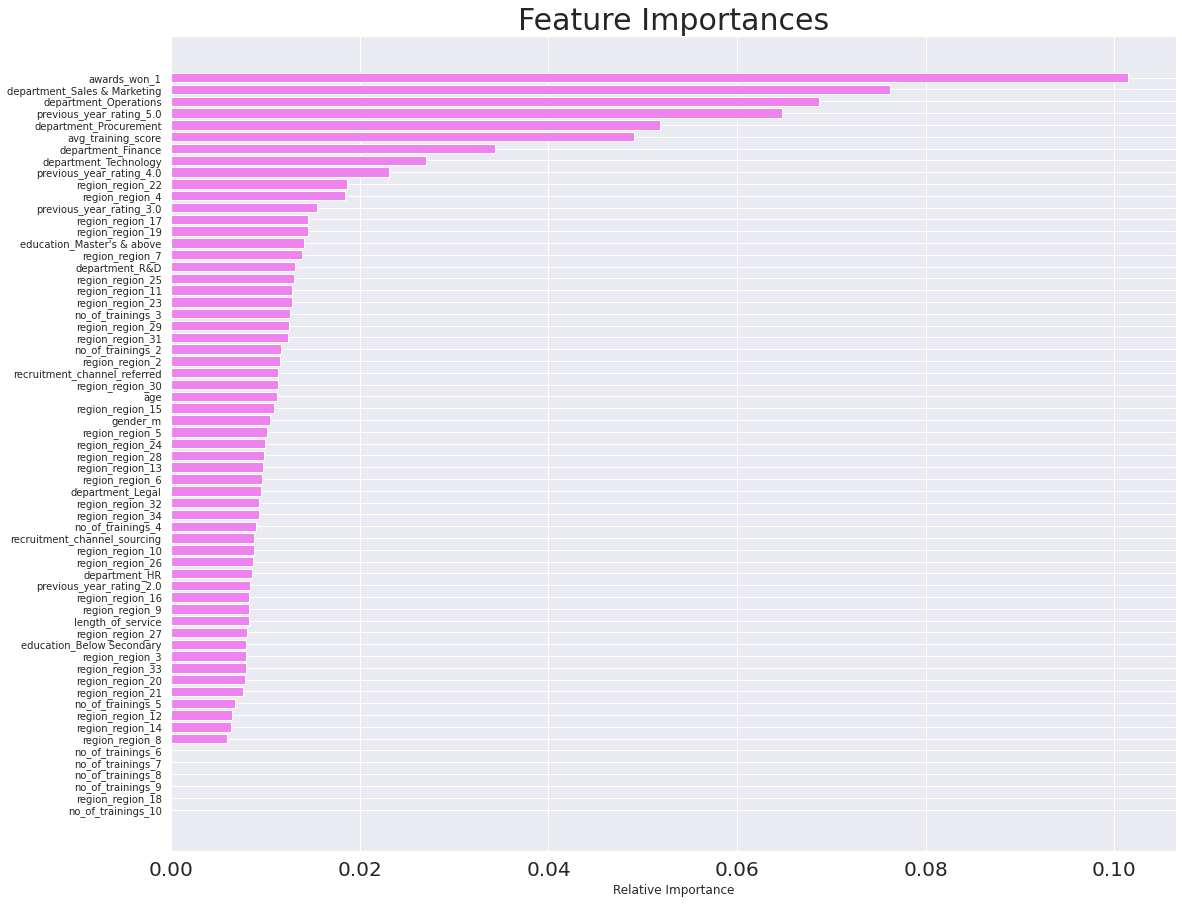

In [94]:
feature_names = X_train.columns
importances = tuned_xgb_original.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18, 15))
plt.title("Feature Importances")
plt.barh(
    range(len(indices)), 
    importances[indices], 
    color="violet", 
    align="center"
)
plt.yticks(
    range(len(indices)), 
    [feature_names[i] for i in indices],
    fontSize=10
)
plt.xlabel("Relative Importance")
plt.show()

#### Most Important Features
For the XGboost_tuned_original model ***awards_won_1***, ***department_Sales & Marketing*** and ***depertment_Operations*** are the top 3 features

### Pipeline
Let's now build a pipeline for XGboost_tuned_original model

Pipeline will have the following steps

1. Data preprocessing
> * For Numeric columnns
>> * Null imputation
> * For Categorrical coumns
>> * Null imputation
>> * One hot encoding
2. Model building

In [96]:
num_cols = [
    col for col in X.columns 
    if X[col].dtype not in ["category", "object"]
]

cat_cols = [
    col for col in X.columns 
    if X[col].dtype in ["category", "object"]
]

In [98]:
# creating a transformer for numerical variables,
# which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

In [100]:
# creating a transformer for categorical variables, 
# which will first apply simple imputer and 
# then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [102]:
# combining categorical transformer and numerical transformer using a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

As we already have identified the best model, we do not need the validation test-data set anymor. 

Let's split the data into only train and test sets.

In [101]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(38365, 11) (16443, 11)


Let put it all together in the pipeline

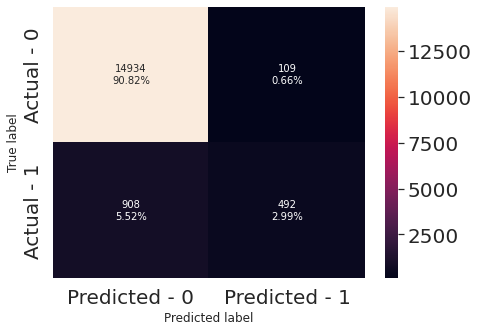

In [103]:
# Creating new pipeline with best parameters
final_model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGboost_tuned_original",
            XGBClassifier(
                random_state=1,
                eval_metric="logloss",
                subsample=0.8,
                scale_pos_weight=2,
                n_estimators=200,
                learning_rate=0.2,
                gamma=1,
            ),
        ),
    ]
)
# Fit the model on training data
final_model.fit(X_train, y_train)

# confusion matrix of the final model
make_confusion_matrix(final_model, X_test, y_test)

## Conclusion & Recommendations 
* We built 6 different base models to predect employee promotion
* After identifying two best models we tuned those with original data, OverSampled data and with UnderSampled data
* Finally we picked the ***XGBoost model tuned with Original data*** as the best model. 
* *XGboost_tuned_original* model provided good accuracy and resonable Recall
* The current data is heavily imbalanced, it will be helpful if more balaanced data having more records for promoted employees is made available
* Previous year's reatings have a clear impact on promotion. Higher the ratings higher are the chances of promotion.
* Winning an award increases the chances of promotion